# Steps:
1. Load data
2. Select relevant candidates/rows
3. Visualize, clean and convert date columns to datetime
    * cdate [DONE]
    * belafspraak [DONE]
    * geboortedatum [DONE]
4. Visualize and clean categorical variables
    * recruitercode [DONE]
    * utm_source -> clean and merge with source [DONE]
    * utm_medium -> clean and merge with medium [DONE]
    * Clean utm_campaign -> clean and merge with campagneNaam -> Split of location from localized campaigns [DONE]
    * clean utm_adgroup -> clean and merge with adgroup -> Split of location from localized ads [DONE]
    * referrer -> clean [DONE]
    * source -> [REMOVED]
    * medium -> [REMOVED]
    * campagneNaam -> [REMOVED]
    * Adgroup -> [REMOVED]
    * conversiepunt -> [DONE]
    * pagina -> clean and create parent_page [DONE]
    * UitkomstTelefonischContact -> [REMOVED] is alleen of het intake is als resultaat UitkostTelefonischDeal
    * UitkomstTelefonischeDeal -> [DONE]
    * postcode -> convert to location -> split in cities, provinces, randstad vs non-randstad [DONE]
    * leeftijd -> clean and add leeftijd_cat [DONE]
    * Ben je in bezit van rijbewijs -> Clean [DONE] maar alleen 1 iemand zonder rijbewijs waarom is dit er nog?
    * beschikking tot eigen vervoer? -> [DONE]
    * Score 1 -> [DONE] wat zijn dit voor vragen en antwoorden? Ik wil hier graag een voorbeeld van zien en is dit over tijd veranderd?
    * Score 2 -> [DONE] wat zijn dit voor vragen en antwoorden? Ik wil hier graag een voorbeeld van zien en is dit over tijd veranderd?
    * Score 3 -> [DONE] wat zijn dit voor vragen en antwoorden? Ik wil hier graag een voorbeeld van zien en is dit over tijd veranderd?
    * Voorkeursbranche -> [DONE]
    * Motivatie  -> [REMOVED] ONBRUIKBAAR WANT OPEN VELD
    * Werksituatie -> [DONE] lijkt iets raars mee te zijn gebeurd
    * Huidig/Laatste functie -> [REMOVED] ONBRUIKBAAR WANT OPEN VELD
    * Hoe lang in dienst/werkloos [DONE]
    * Meest trotste project -> [REMOVED] open vraag onbruikbaar
    * Strevon startsalaris [DONE]
    * Strevon werktijden [DONE]
    * Verloning marge stopper of W&S overname -> Wacht op toelichting
    * Overname bedrag (W&S) -> Wacht op toelichting
    * groupid
    * stage
    * status
    * starter 
    * berekening - Wacht op toelichting
5. 
6. Visualize and clean continous variable
7. Perform correlation analyses on variables
8. Visualize correlation results
9. Create report  

## Questions
1. At utm_source I replaced werkenbijstrevon with strevon because I figured this is probably the same source. Is this correct?
2. At utm_source I replaced the following values with other: '8kvl4ikw535', 'l', 'ecosia', 'duckduckgo', 'linktr',
       'com', 'googleadservices', 'm', 'nl', 'youtube'. Since there were less then 10 cases of these values. Do you agree?
3. Should we remove everybody without priority 1? Because there are some cases wheren people with starter 1 don't have priority 1.
4. Why do utm_medium and medium not align. How was this database created? Are we sure each data represents a unique candidate???

### 1. Load data

In [1]:
import os
import pandas as pd
import numpy as np

#load orignal data
file_path = os.path.join(os.curdir,'data','Kopie van BastianLewisData.xlsx')
df = pd.read_excel(file_path,sheet_name='Result 1')


In [2]:
#load latest data
file_path = os.path.join(os.curdir,'data','StrevonExport.xlsx')
df = pd.read_excel(file_path,sheet_name='StrevonExport')


In [3]:
var_file_path = os.path.join(os.curdir,'data','Kopie van BastianLewisData.xlsx')
df_vars = pd.read_excel(var_file_path,sheet_name='VariableSelection')
var_drop = list(df_vars['Name'][df_vars['Status'] == 'Drop'])

df.drop(labels = var_drop,  axis= 1, inplace = True)

### 2. Select relevant candidates/rows

In [4]:
# alleen 'prioriteit' = 1 houden & geen afwijsBasisGegevens (isnull) 
print('unique prioriteit values:',  df['prioriteit'].unique())
print('unique afwijsBasisGegevens values:',  df['afwijsBasisGegevens'].unique())

df = df[df['prioriteit'] == 1]
df = df[pd.isnull(df['afwijsBasisGegevens'])]
df.drop(labels = ['prioriteit','afwijsBasisGegevens'],  axis= 1, inplace = True)

unique prioriteit values: [nan  3.  1.  2.  4.]
unique afwijsBasisGegevens values: [nan 'postal_code' 'drivers_license' 'age' 'dutch_language_skill']


In [5]:
len(df)

4088

In [6]:
df['starter'].value_counts()

0    3946
1     142
Name: starter, dtype: int64

### 3. Conver datetime variables to datetime

In [7]:
# convert date strings to datetime
def clean_date_columns(df: pd.DataFrame, date_columns: list) -> pd.DataFrame:
    for date_col in date_columns: 
        df[date_col] = pd.to_datetime(df[date_col], utc=True, errors='coerce')
    return df

df = clean_date_columns(df, ['cdate', 'belafspraak', 'geboortedatum'])

### 4. Clean categorical variables

In [8]:
# Cleaning values with low frequency <10
def clean_categorical_variable(df: pd.DataFrame, column_name: str):
    print(f"working on {column_name}")
    print(f"{len(df[df[column_name].isna()])} missings")
    print("recategorizing all values that appear less then 10 times to 'other'")

    value_counts = df[column_name].value_counts()
    values_to_replace = value_counts[value_counts < 10].index
    values_to_keep = value_counts[value_counts >= 10].index
    df[column_name] = df[column_name].apply(lambda x: 'other' if x in values_to_replace else x)
    print(f"replaced the following values with other: {values_to_replace}")
    print(f"Keeping the following values: {values_to_keep}")
    print("_________________________")
    return df

import matplotlib.pyplot as plt
import seaborn as sns

def plot_categorical_distribution(df, column):
    # Count occurrences of each category
    value_counts = df[column].value_counts()

    # Identify categories that occur less than 10 times
    rare_categories = value_counts[value_counts < 10].index

    # Replace rare categories with 'Other'
    # df[column] = df[column].apply(lambda x: 'Other' if x in rare_categories else x)

    # Count occurrences again after grouping rare categories
    value_counts = df[column].value_counts()

    # Plot the distribution
    plt.figure(figsize=(10, 6))
    sns.barplot(x=value_counts.index, y=value_counts.values, palette='viridis')
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

# for column_name in object_columns:
#     clean_categorical_variable(df, column_name)

# object_columns = df.select_dtypes(include='object').columns.tolist()
# other_columns = ['postcode','leeftijd','motivatie',"Huidig/Laatste functie","Hoe lang in dienst/werkloos","Meest trotste project"]
# for col in other_columns:
#     if col in object_columns:
#         object_columns.remove(col)

In [9]:
# for col in df.columns.to_list():
#     print(f"* {col}")

### cleaning and merging utm_source and source

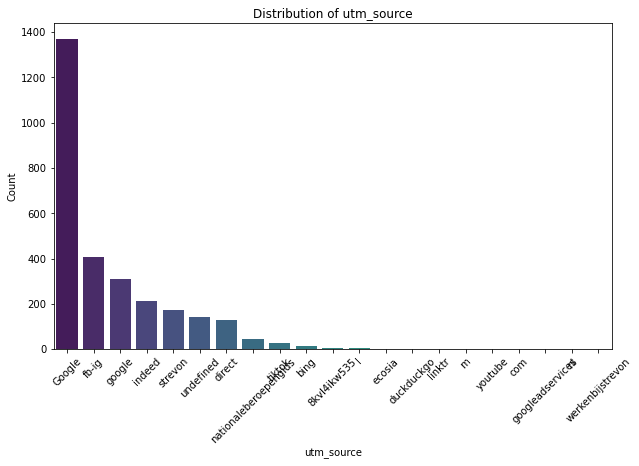

In [53]:
column = "utm_source"
plot_categorical_distribution(df, column)

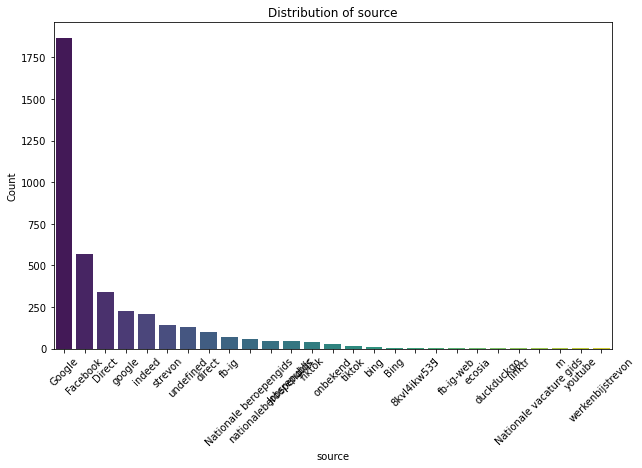

In [54]:
column = "source"
plot_categorical_distribution(df, column)

In [55]:
df['source'].value_counts()

Google                     1867
Facebook                    569
Direct                      340
google                      226
indeed                      207
strevon                     142
undefined                   129
direct                       98
fb-ig                        68
Nationale beroepengids       56
nationaleberoepengids        46
Jobsrepublic                 44
Tiktok                       42
onbekend                     27
tiktok                       17
bing                         10
Bing                          5
8kvl4ikw535                   4
l                             3
fb-ig-web                     3
ecosia                        3
duckduckgo                    2
linktr                        1
Nationale vacature gids       1
m                             1
youtube                       1
werkenbijstrevon              1
Name: source, dtype: int64

In [10]:
def clean_and_combine_source_columns(df):
    df['source'] = df['source'].str.lower()
    df['source'] = df['source'].replace("nationale beroepengids", "nationaleberoepengids")
    df['source'] = df['source'].replace("werkenbijstrevon", "strevon")
    df['source'] = df['source'].replace("onbekend", "undefined")
    df['source'] = df['source'].fillna(df['utm_source'])
    clean_categorical_variable(df, 'source')

    df['utm_source'] = df['utm_source'].str.lower()
    df["utm_source"].replace('werkenbijstrevon', 'strevon',inplace=True) #Mag dit is dit hetzelfde?
    df['source'] = df['source'].replace("direct","strevon")
    df['utm_source'] = df['utm_source'].replace("direct","strevon")
    df['utm_source'] = df['utm_source'].fillna(df['source'])
    clean_categorical_variable(df, 'utm_source')

    column_a = 'utm_source'
    column_b = 'source'
    x = "undefined"
    df[column_a] = df.apply(lambda row: row[column_b] if row[column_a] == x else row[column_a], axis=1)

    column_a = 'source'
    column_b = 'utm_source'
    x = "undefined"
    df[column_a] = df.apply(lambda row: row[column_b] if row[column_a] == x else row[column_a], axis=1)

    column_a = 'source'
    column_b = 'utm_source'
    x = "facebook"
    df[column_a] = df.apply(lambda row: row[column_b] if row[column_a] == x else row[column_a], axis=1)

    ## Drop source and keep utm_source
    df.drop(['source'], axis=1, inplace=True)
    return df

df = clean_and_combine_source_columns(df)

working on source
172 missings
recategorizing all values that appear less then 10 times to 'other'
replaced the following values with other: Index(['8kvl4ikw535', 'fb-ig-web', 'ecosia', 'l', 'duckduckgo',
       'nationale vacature gids', 'm', 'youtube', 'Google', 'linktr'],
      dtype='object')
Keeping the following values: Index(['google', 'facebook', 'direct', 'indeed', 'undefined', 'strevon',
       'nationaleberoepengids', 'fb-ig', 'tiktok', 'jobsrepublic', 'bing'],
      dtype='object')
_________________________
working on utm_source
172 missings
recategorizing all values that appear less then 10 times to 'other'
replaced the following values with other: Index(['jobsrepublic', '8kvl4ikw535', 'other', 'l', 'duckduckgo', 'ecosia',
       'linktr', 'nl', 'youtube', 'm', 'com', 'googleadservices'],
      dtype='object')
Keeping the following values: Index(['google', 'strevon', 'fb-ig', 'facebook', 'indeed', 'undefined',
       'nationaleberoepengids', 'tiktok', 'bing'],
      dtype=

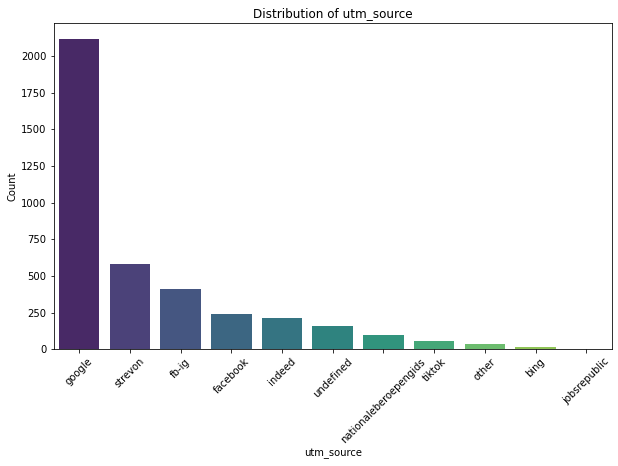

In [57]:
column = "utm_source"
plot_categorical_distribution(df, column)

### Visualizing, cleaning and merging utm_medium and medium

BEFORE


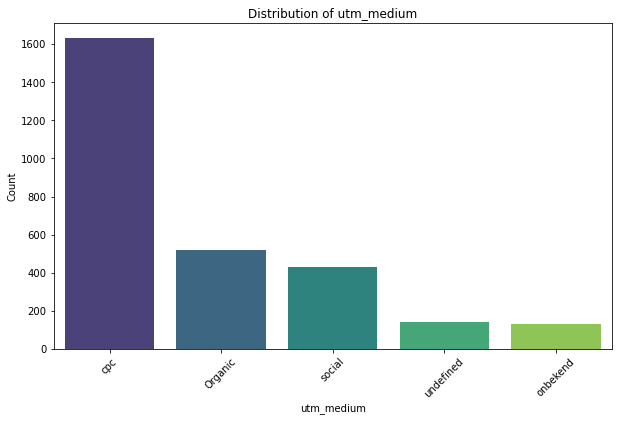

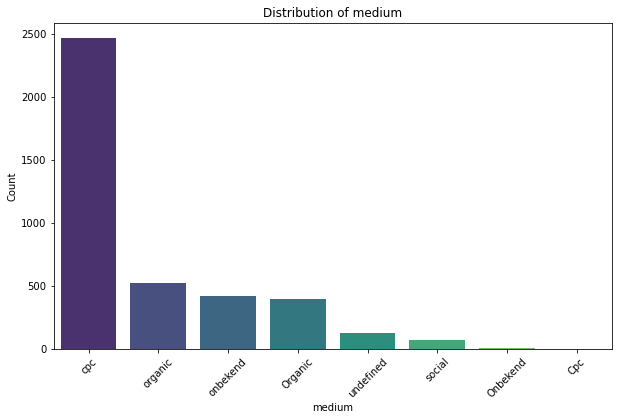

AFTER


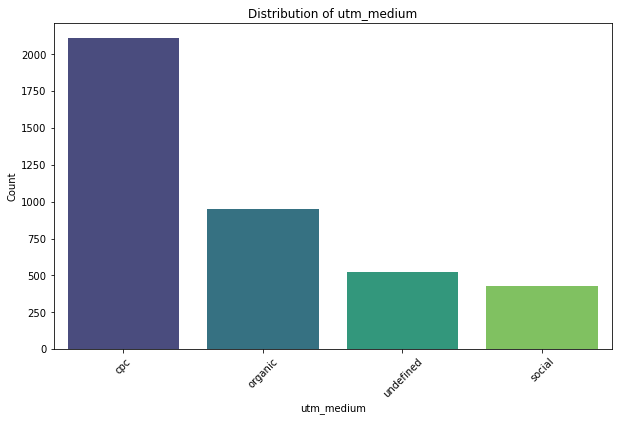

In [11]:
print("BEFORE")
column = "utm_medium"
plot_categorical_distribution(df, column)

column = "medium"
plot_categorical_distribution(df, column)

def merging_two_columns(df, column_a, column_b):
    # Visualizeing, Cleaning and merging utm_medium and medium
    df[column_b] = df[column_b].str.lower()
    df[column_b] = df[column_b].replace("onbekend", "undefined")

    df[column_a] = df[column_a].str.lower()
    df[column_a] = df[column_a].replace("onbekend","undefined")
    df[column_a] = df[column_a].fillna(df[column_b])

    x = "undefined"
    df[column_a] = df.apply(lambda row: row[column_b] if row[column_a] == x else row[column_a],
                            axis=1)

    df.drop(column_b, axis=1, inplace = True)
    return df

df = merging_two_columns(df, "utm_medium", "medium")
print("AFTER")
column = "utm_medium"
plot_categorical_distribution(df, column)

### Visualize, Clean and Merge utm_campaign and campagneNaam

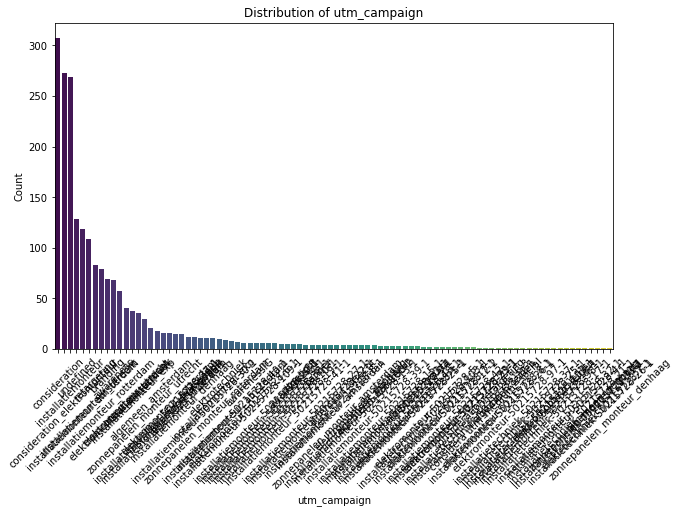

In [59]:
column = "utm_campaign"
plot_categorical_distribution(df, column)

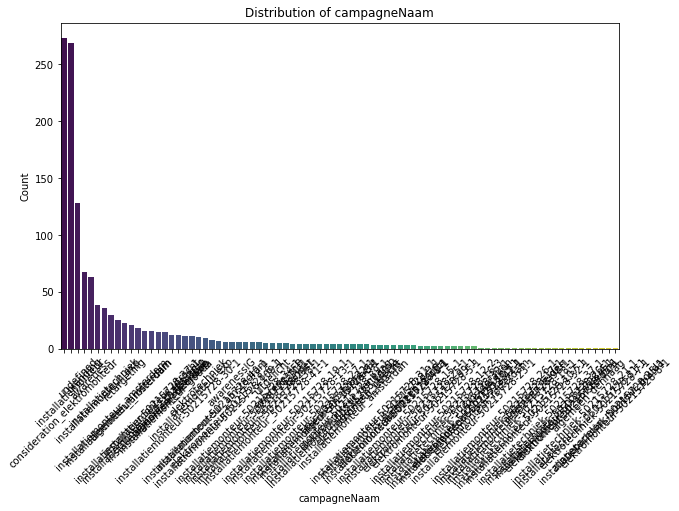

In [60]:
column = "campagneNaam"
plot_categorical_distribution(df, column)

In [12]:
def clean_utm_campaign(df):
    # cleaning utm_campaign
    column_name = 'utm_campaign'
    df[column_name].replace('installatiemonteur_amstedram', 'installatiemonteur_amsterdam', inplace=True) #Mag dit is dit hetzelfde?
    df[column_name].replace('installatiemonteur_amsterdan', 'installatiemonteur_amsterdam', inplace=True) #Mag dit is dit hetzelfde?
    
    installatiemonteur_values = [val for val in df['utm_campaign'].unique() if "installatiemonteur-" in str(val)]
    installatiemonteur_values.remove('installatiemonteur-exp')
    for val in installatiemonteur_values:
        df[column_name].replace(val, 'installatiemonteur', inplace=True)

    elektromonteur_values = [val for val in df['utm_campaign'].unique() if "elektromonteur-" in str(val)]
    elektromonteur_values += ["elektromonteur50215728-102-1"]
    for val in elektromonteur_values:
        df[column_name].replace(val, 'elektromonteur', inplace=True)

    installatietechniek_values = [val for val in df['utm_campaign'].unique() if "installatietechniek-" in str(val).lower()]
    for val in installatietechniek_values:
        df[column_name].replace(val, 'installatietechniek', inplace=True)

    elektrotechniek_values = [val for val in df['utm_campaign'].unique() if "elektrotechniek-" in str(val).lower()]
    for val in elektrotechniek_values:
        df[column_name].replace(val, 'elektrotechniek', inplace=True)
    return df

In [13]:
df = clean_utm_campaign(df)

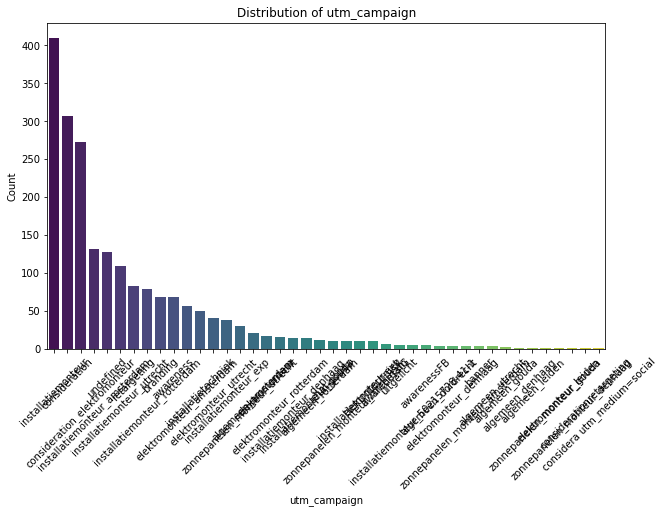

In [64]:
column = "utm_campaign"
plot_categorical_distribution(df, column)

In [14]:
def split_campaign_locations(df):
    #create location of utm_campaign variable
    df["utm_campaign_location"] = df["utm_campaign"].apply(lambda x: str(x).split("_")[-1] if len(str(x).split("_")) > 0 else None)
    locations=['amsterdam','utrecht','dordrecht','leiden','gouda','denhaag','utrecht','rotterdam']
    df["utm_campaign_location"] = df["utm_campaign_location"].apply(lambda x: x if x in locations else None)
    #remove locations from utm_campaigns
    df["utm_campaign_no_loc"] = df["utm_campaign"].apply(lambda x: "_".join(str(x).split("_")[:-1]) if str(x).split("_")[-1] in locations else x)
    return df

In [15]:
df = split_campaign_locations(df)

In [16]:
df = clean_categorical_variable(df, "utm_campaign_no_loc")

working on utm_campaign_no_loc
2025 missings
recategorizing all values that appear less then 10 times to 'other'
replaced the following values with other: Index(['awarenessIG', 'uitgelicht', 'installatiemonteur_50215728-41-1',
       'awarenessFB', 'banner', 'considerationretargeting',
       'considera utm_medium=social'],
      dtype='object')
Keeping the following values: Index(['installatiemonteur', 'consideration', 'consideration_elektromonteur',
       'elektromonteur', 'undefined', 'retargeting', 'branding', 'awareness',
       'installatietechniek', 'zonnepanelen_monteur', 'algemeen',
       'installatiemonteur_exp', 'chat-popup', 'installatiemonteur-exp',
       'elektrotechniek'],
      dtype='object')
_________________________


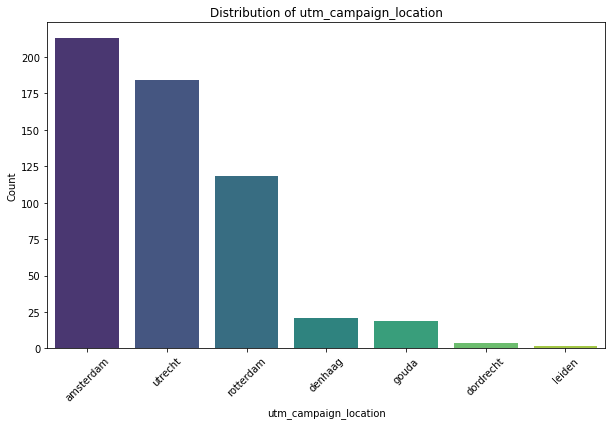

In [68]:
column = "utm_campaign_location"
plot_categorical_distribution(df, column)

In [69]:
df['utm_campaign'].value_counts()

installatiemonteur                  409
consideration                       307
consideration_elektromonteur        273
installatiemonteur_amsterdam        131
undefined                           128
installatiemonteur_utrecht          109
retargeting                          83
installatiemonteur_rotterdam         79
branding                             69
awareness                            68
elektromonteur_amsterdam             57
installatietechniek                  50
elektromonteur_utrecht               41
installatiemonteur_exp               38
zonnepanelen_monteur_utrecht         30
algemeen_amsterdam                   21
elektromonteur                       17
elektromonteur_rotterdam             16
installatiemonteur_denhaag           15
installatiemonteur_gouda             15
algemeen_rotterdam                   12
chat-popup                           11
zonnepanelen_monteur_rotterdam       11
installatiemonteur-exp               11
elektrotechniek                      11


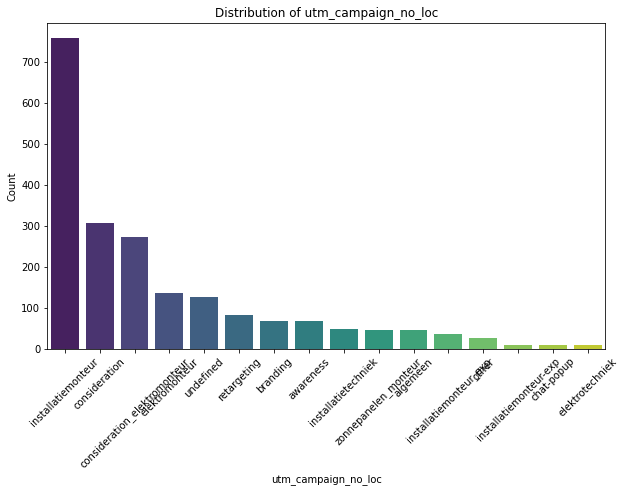

In [70]:
column = "utm_campaign_no_loc"
plot_categorical_distribution(df, column)

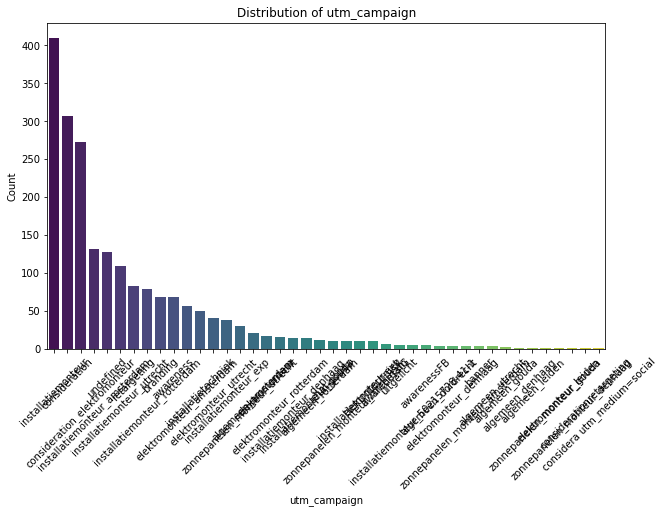

In [71]:
column = "utm_campaign"
plot_categorical_distribution(df, column)

In [17]:
# CampagneNaam is same as utm_campaign so drop
df.drop(['campagneNaam'], axis=1, inplace=True)

## Visualize, clean and merge utm_adgroup and adgroup

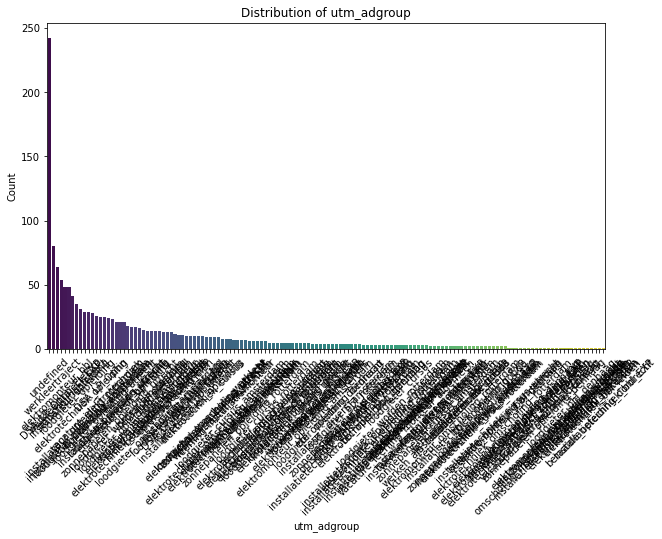

In [73]:
column = "utm_adgroup"
plot_categorical_distribution(df, column)

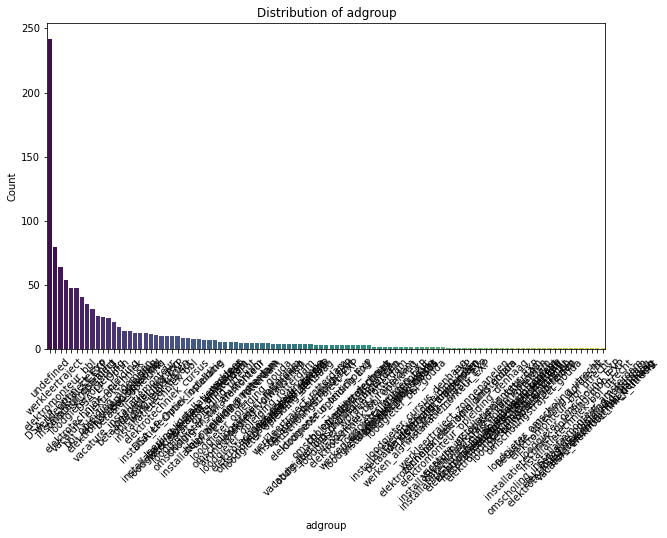

In [74]:
column = "adgroup"
plot_categorical_distribution(df, column)

In [18]:
def split_adgroup_locations(df):
    #create location of utm_adgroup variable
    column_name = "utm_adgroup"
    df["utm_adgroup_location"] = df[column_name].apply(lambda x: str(x).split("_")[-1] if len(str(x).split("_")) > 0 else None)
    locations=['amsterdam','utrecht','dordrecht','leiden','gouda','denhaag','utrecht','rotterdam']
    df["utm_adgroup_location"] = df["utm_adgroup_location"].apply(lambda x: x if x in locations else None)
    #remove locations from utm_campaigns
    df[column_name+"_no_loc"] = df[column_name].apply(lambda x: "_".join(str(x).split("_")[:-1]) if str(x).split("_")[-1] in locations else x)
    df = clean_categorical_variable(df, column_name+"_no_loc")
    column_name = "utm_adgroup"
    df = clean_categorical_variable(df, column_name)
    return df

In [20]:
df = split_adgroup_locations(df)

working on utm_adgroup_no_loc
2570 missings
recategorizing all values that appear less then 10 times to 'other'
replaced the following values with other: Index(['omscholing_installatiemonteur', 'leerling_installatiemonteur',
       'elektromonteur_omscholing', 'installatietechniek_omscholing',
       'werkleer', 'elektrotechniek_opleiding_mbo',
       'avondopleiding_volwassenen', 'installateur_opleiding_EXP',
       'installatietechniek_cursus', 'loodgieter_bbl_EXP',
       'vacature_leerling_monteur_algemeen', 'omscholingstraject_EXP',
       'elektrotechniek_bbl_opleiding', 'omscholen_elektrotechniek',
       'loodgieter_opleiding_EXP', 'installateur__divers_EXP',
       'werken_als_installatiemonteur_EXP', 'loodgieter_worden_EXP',
       'werken_als_installatiemonteur', 'werkleertraject_algemeen',
       'installatietechniek_opleiding_EXP', 'elektricien_omscholen',
       'omscholingstraject_zonnepanelen', 'werkleertraject_zonnepanelen',
       'installatietechniek_bbl_EXP', 'vacat

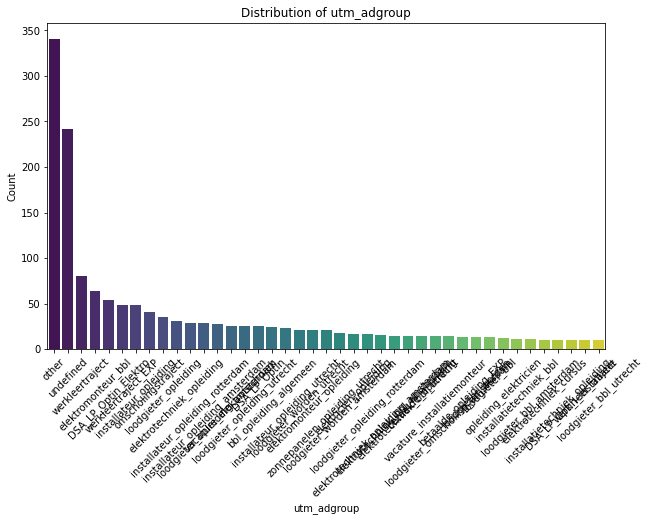

In [ ]:
column = "utm_adgroup"
plot_categorical_distribution(df, column)

In [ ]:
df['utm_adgroup'].value_counts()

other                                  341
undefined                              242
werkleertraject                         80
elektromonteur_bbl                      64
DSA_LP_Optin_Elektro                    54
werkleertraject_EXP                     48
installateur_opleiding                  48
omscholingstraject                      41
loodgieter_opleiding                    35
elektrotechniek_opleiding               31
installateur_opleiding_rotterdam        29
installateur_opleiding_amsterdam        29
loodgieter_opleiding_amsterdam          28
vacature_elektrotechniek                26
loodgieter_opleiding_utrecht            25
DSA_LP_Optin                            25
bbl_opleiding_algemeen                  24
installateur_opleiding_utrecht          23
loodgieter_worden_utrecht               21
elektromonteur_opleiding                21
zonnepanelen_opleiding_utrecht          21
loodgieter_worden_amsterdam             18
elektricien_opleiding                   17
loodgieter_

### cleaning referrer

In [22]:
def clean_referrer_column(df):    
    values = ['strevon.nl', 'www.google.com', 'direct', 'm.facebook.com', np.nan,
        'www.google.nl', 'www.nationaleberoepengids.nl',
        'www.adsensecustomsearchads.com', 'nl.indeed.com',
        'www.ecosia.org', 'duckduckgo.com', 'www.bing.com', 'linktr.ee',
        'www.google.de', 'www.google.com.tr', 'www.google.ae',
        'www.google.it', '8kvl4ikw535.typeform.com', 'www.google.co.jp',
        'l.facebook.com', 'undefined', 'www.youtube.com', 'l.wl.co',
        'com.google.android.googlequicksearchbox',
        'www.googleadservices.com', 'www.google.co.za', 'typeform.com',
        'www.google.fr', 'werkenbijstrevon.nl', 'l.instagram.com',
        'nl.search.yahoo.com', 'lm.facebook.com', 'www.tiktok.com',
        'instagram.com', 'android-app:', 'www.google.ch',
        'strevon-nl.webpkgcache.com', 'web.telegram.org',
        'syndicatedsearch.goog']

    google_values = [val for val in values if 'google' in str(val)]
    facebook_values = [val for val in values if 'facebook' in str(val)]
    strevon_values = [val for val in values if 'strevon' in str(val)] + ["direct"]

    df['referrer'] =  df['referrer'].apply(lambda x: 'google' if str(x) in google_values else x)
    df['referrer'] =  df['referrer'].apply(lambda x: 'facebook' if str(x) in facebook_values else x)
    df['referrer'] =  df['referrer'].apply(lambda x: 'strevon' if str(x) in strevon_values else x)
    clean_categorical_variable(df, 'referrer')


    df['referrer'] = df['referrer'].str.replace(".com",'')
    df['referrer'] =df['referrer'].str.replace("www.",'')
    df['referrer'] =df['referrer'].str.replace("nl.",'')
    df['referrer'] =df['referrer'].str.replace(".nl",'')
    return df

In [23]:
df = clean_referrer_column(df)

working on referrer
693 missings
recategorizing all values that appear less then 10 times to 'other'
replaced the following values with other: Index(['duckduckgo.com', 'www.nationaleberoepengids.nl', 'linktr.ee',
       'www.ecosia.org', 'nl.search.yahoo.com', 'www.youtube.com',
       'android-app:', 'l.wl.co', 'typeform.com', 'syndicatedsearch.goog',
       'l.instagram.com', 'web.telegram.org'],
      dtype='object')
Keeping the following values: Index(['google', 'strevon', 'facebook', 'undefined', 'instagram.com',
       'www.tiktok.com', 'nl.indeed.com', '8kvl4ikw535.typeform.com',
       'www.adsensecustomsearchads.com', 'www.bing.com'],
      dtype='object')
_________________________


<ipython-input-22-fec4cc786774>:27: FutureWarning: The default value of regex will change from True to False in a future version.
  df['referrer'] = df['referrer'].str.replace(".com",'')
<ipython-input-22-fec4cc786774>:28: FutureWarning: The default value of regex will change from True to False in a future version.
  df['referrer'] =df['referrer'].str.replace("www.",'')
<ipython-input-22-fec4cc786774>:29: FutureWarning: The default value of regex will change from True to False in a future version.
  df['referrer'] =df['referrer'].str.replace("nl.",'')
<ipython-input-22-fec4cc786774>:30: FutureWarning: The default value of regex will change from True to False in a future version.
  df['referrer'] =df['referrer'].str.replace(".nl",'')


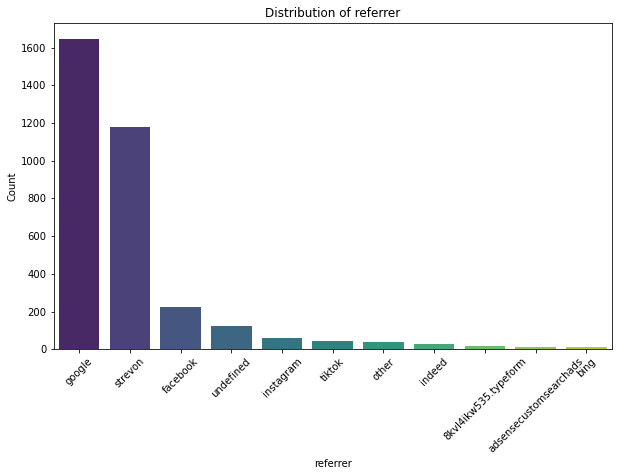

In [24]:
column = "referrer"
plot_categorical_distribution(df, column)

## Conversiepunt Visualize if needed clean

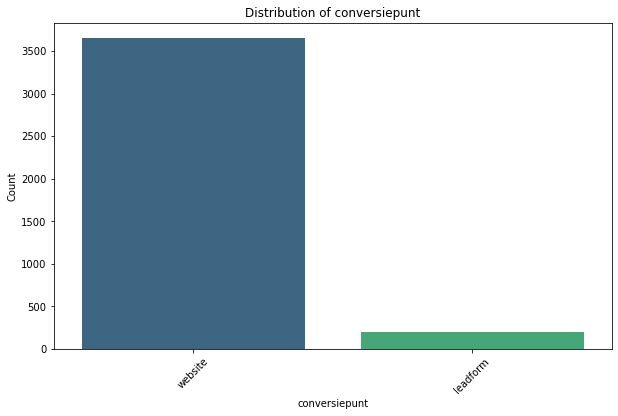

In [45]:
column = 'conversiepunt'
df[column] = df[column].str.lower()
plot_categorical_distribution(df, column)

## Pagina visualize and clean if needed 

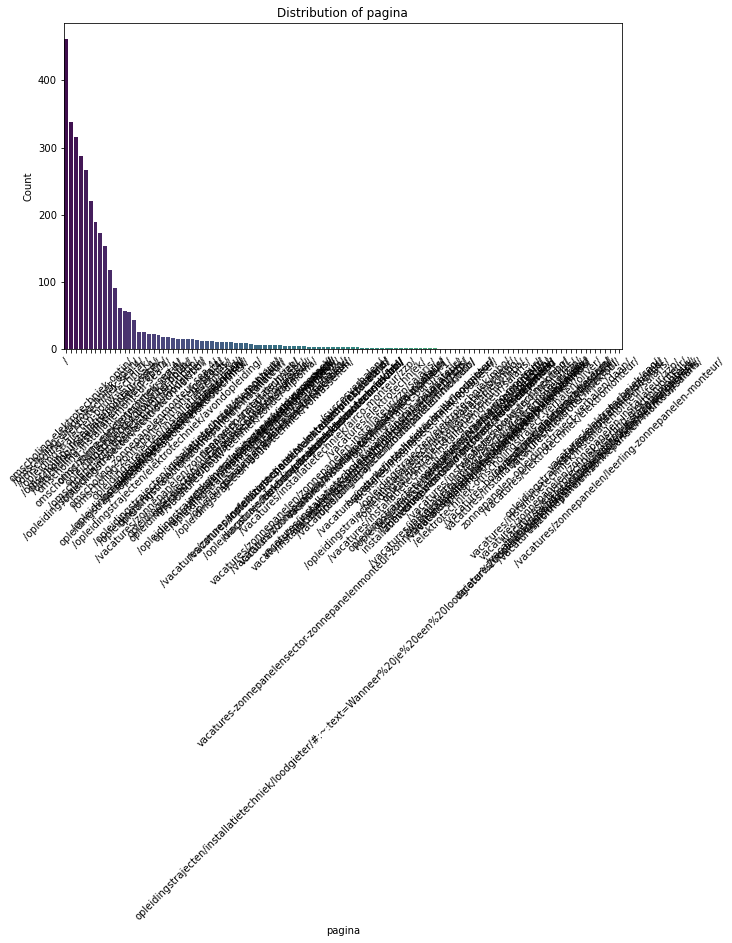

In [46]:
column = 'pagina'
plot_categorical_distribution(df, column)

In [25]:
def convert_pagina_to_parent_page(df):
    column = 'pagina'
    df[column] = df[column].apply(lambda x: x.strip("/") if type(x)==str else x)
    df['parent_page'] = df[column].apply(lambda x: x.split("/")[0] if type(x)==str else x)
    return df

In [26]:
df = convert_pagina_to_parent_page(df)

In [28]:
len(df['parent_page'].unique())

28

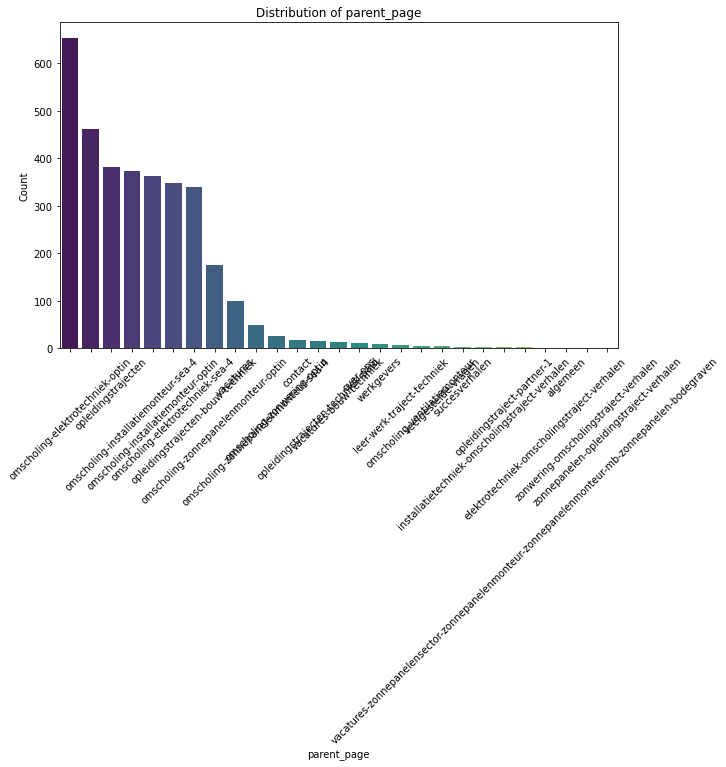

In [49]:
column = 'parent_page'
plot_categorical_distribution(df,column)

## UitkomstTelefonischContact en UitkomstTelefonischDeal Visualize and Clean

In [29]:
def merge_UitkomstTelefonisch(df):
    df['uitkomstTelefonischDeal'] = df['uitkomstTelefonischDeal'].fillna(df["uitkomstTelefonischContact"])
    df.drop(column, axis=1, inplace=True)
    return df

In [30]:

column = "uitkomstTelefonischDeal"

google                    1647
strevon                   1181
facebook                   226
undefined                  123
instagram                   60
tiktok                      46
other                       37
indeed                      27
8kvl4ikw535.typeform        19
adsensecustomsearchads      15
bing                        14
Name: referrer, dtype: int64

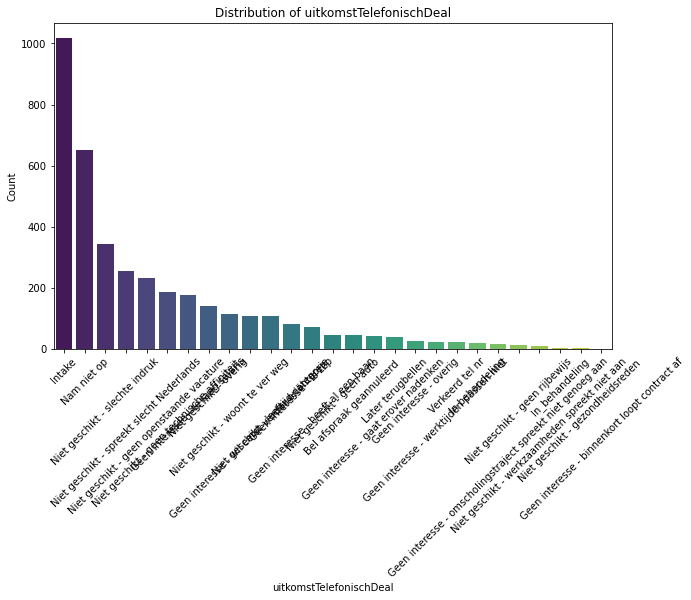

In [31]:

plot_categorical_distribution(df,column)


## Visualizing and Cleaning leeftijd

In [53]:
df['leeftijd'].unique()

array(['18-30 jaar', '31-49 jaar', nan, 45, 38, 39, 31, 40, 50,
       '50 jaar of ouder', 34, 26, 42, 30, 32, 36, 28, 25, 35, 27, 22, 41,
       46, 23, 24, 49, 43, 21, 19, 20, 37, 33, 48, 47, 29, 1, 44, 51, 18,
       0, 17], dtype=object)

In [34]:
import random

def categorize(x):
    if (x>0) & (x<31):
        return "18-30 jaar"
    elif (x>30) & (x<50):
        return "31-49 jaar"
    elif x > 49:
        return "50 jaar of ouder"
    else:
        return np.nan

def cleaning_leeftijd(df):
    df['leeftijd'] = df['leeftijd'].apply(lambda x: str(random.choice(range(18,30))) if x=="18-30 jaar" else x)
    df['leeftijd'] = df['leeftijd'].apply(lambda x: str(random.choice(range(31,49))) if x=="31-49 jaar" else x)
    df['leeftijd'] = df['leeftijd'].apply(lambda x: str(random.choice(range(31,45))) if x=="31-45 jaar" else x)
    df['leeftijd'] = df['leeftijd'].apply(lambda x: str(random.choice(range(50,65))) if x=="50 jaar of ouder" else x)
    df['leeftijd'] = df['leeftijd'].apply(float)
    df['leeftijd'] = df['leeftijd'].replace(0,np.nan)
    df['leeftijd'] = df['leeftijd'].replace(1,np.nan)

    df['leeftijd_cat'] = df['leeftijd'].apply(lambda x: categorize(x))
    return df


In [35]:
df = cleaning_leeftijd(df)

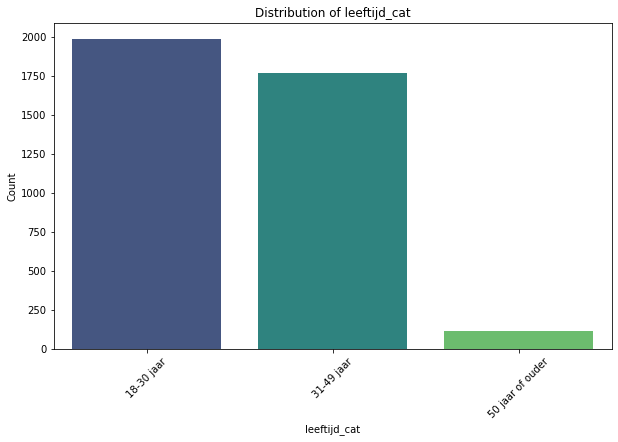

In [36]:
column = 'leeftijd_cat'
plot_categorical_distribution(df,column)

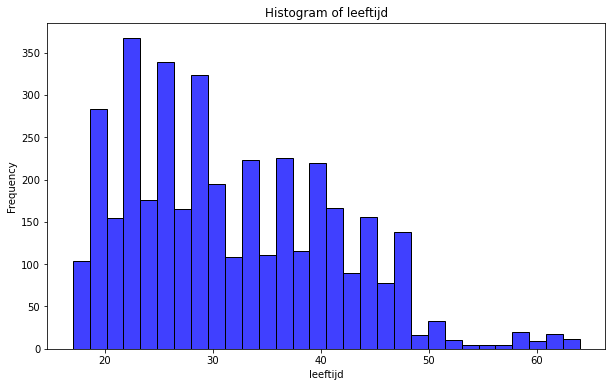

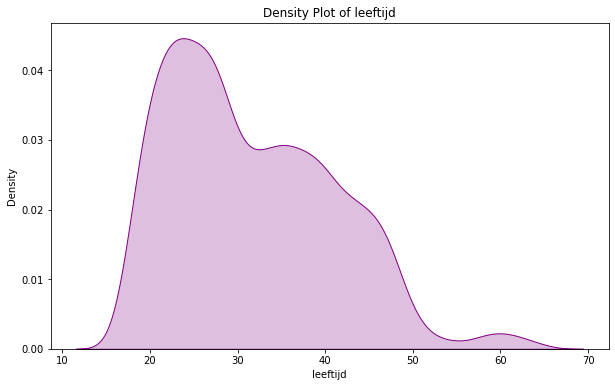

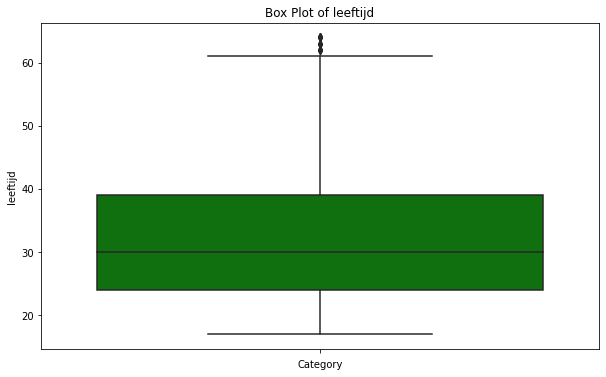

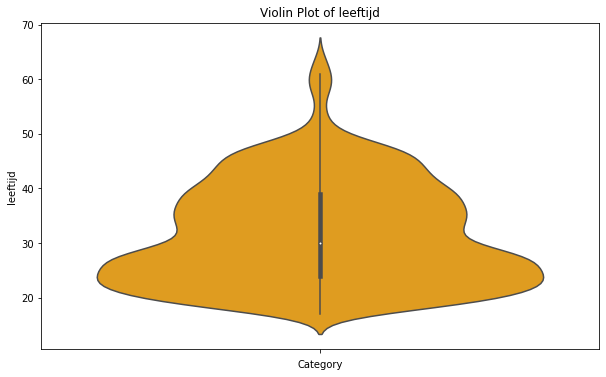

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_histogram(df, column, bins=30):
    plt.figure(figsize=(10, 6))
    sns.histplot(df[column], bins=bins, kde=False, color='blue')
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

def plot_density(df, column):
    plt.figure(figsize=(10, 6))
    sns.kdeplot(df[column], shade=True, color='purple')
    plt.title(f'Density Plot of {column}')
    plt.xlabel(column)
    plt.ylabel('Density')
    plt.show()

def plot_boxplot(df, column):
    plt.figure(figsize=(10, 6))
    sns.boxplot(y=df[column], color='green')
    plt.title(f'Box Plot of {column}')
    plt.xlabel('Category')
    plt.ylabel(column)
    plt.show()

def plot_violinplot(df, column):
    plt.figure(figsize=(10, 6))
    sns.violinplot(y=df[column], color='orange')
    plt.title(f'Violin Plot of {column}')
    plt.xlabel('Category')
    plt.ylabel(column)
    plt.show()

plot_histogram(df, 'leeftijd')
plot_density(df, 'leeftijd')
plot_boxplot(df, 'leeftijd')
plot_violinplot(df, 'leeftijd')


## Ben je in het bezit van een rijbewijs

In [61]:
def clean_rijbewijs(df):
    column ="Ben je in het bezit van rijbewijs?"
    df[column] = df[column].str.lower()
    df[column] = df[column].str.strip(",")
    return df
df = clean_rijbewijs(df)
df[column].value_counts()

ja     1749
nee       1
Name: Ben je in het bezit van rijbewijs?, dtype: int64

## beschikking tot eigen vervoer?

In [43]:
def clean_eigen_vervoer(df):
    column = "beschikking tot eigen vervoer?"
    df[column] = df[column].str.lower()
    df[column] = df[column].apply(lambda x: "nee dit heb ik niet" if str(x) in ["geen auto","geen vervoer"] else x)
    df[column] = df[column].apply(lambda x: "ja een eigen auto of motor" if "motor" in str(x) else x)
    df[column] = df[column].apply(lambda x: "ja een eigen auto of motor" if "auto" in str(x) else x)
    df[column] = df[column].apply(lambda x: "ja een eigen auto of motor" if str(x)=="ja" else x)
    df[column] = df[column].apply(lambda x: "nee dit heb ik niet" if str(x)=="nee" else x)
    return df
df = clean_eigen_vervoer(df)
df["beschikking tot eigen vervoer?"].value_counts()

ja een eigen auto of motor    1249
nee dit heb ik niet            393
ja een eigen scooter           107
Name: beschikking tot eigen vervoer?, dtype: int64

## Score 1

In [45]:
def clean_score_1(df):
    column = 'score 1'
    answer_options = ["Laminaat leggen, lampen aansluiten op elektra, sleutelen aan scooter/auto",
                    "Gordijnen ophangen, batterij vervangen rookmelder, lampje verwisselen",
                    "Meer dan een half jaar ervaring in een technische functie (bijvoorbeeld monteur)"]
    df[column] = df[column].apply(lambda x: x if x in answer_options else np.nan)
    return df

df = clean_score_1(df)

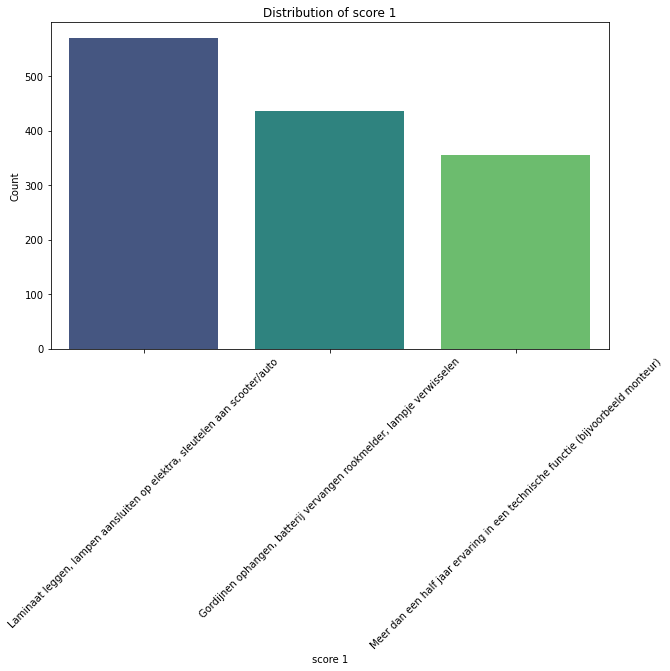

In [65]:
plot_categorical_distribution(df, column)

In [66]:
column = 'score 2'
df[column].value_counts()
#plot_categorical_distribution(df, column)

Houtwerk schilderen, leidingen verleggen, vervangen van kapotte stopcontacten       393
Meer dan een half jaar ervaring in een technische functie (bijvoorbeeld monteur)    338
Stofzuigerzak vervangen, verwijderen oude poster, dakgoot schoonmaken               244
Laminaat leggen, lampen aansluiten op elektra, sleutelen aan scooter/auto           209
Gordijnen ophangen, batterij vervangen rookmelder, lampje verwisselen               166
Name: score 2, dtype: int64

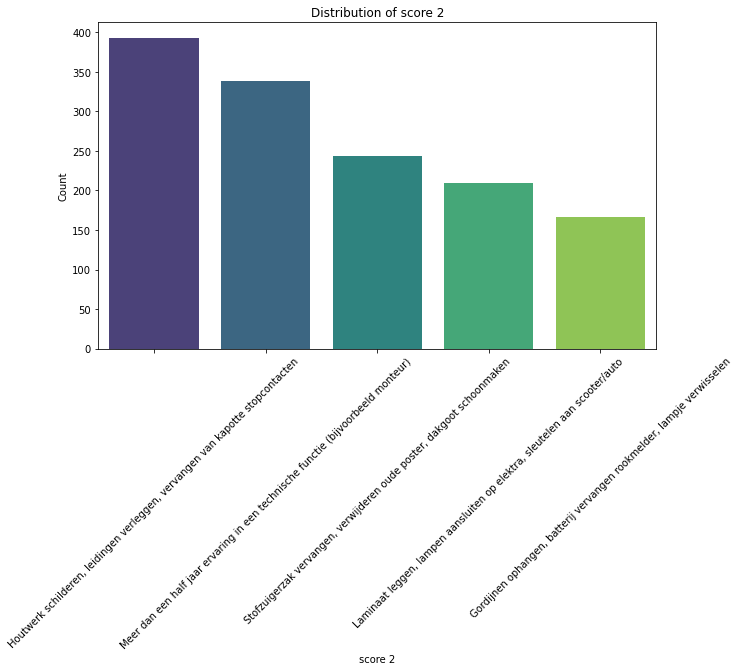

In [67]:
plot_categorical_distribution(df, column)

In [68]:
column = 'score 3'
df[column].value_counts()
#plot_categorical_distribution(df, column)

Kast in elkaar zetten, monteren nieuwe douchekop, deurbel installeren                     818
Meer dan een half jaar ervaring in een technische functie (bijvoorbeeld monteur)          318
Vervangen batterij afstandsbediening, schoonmaken afzuigkap, vastdraaien losse schroef    211
Name: score 3, dtype: int64

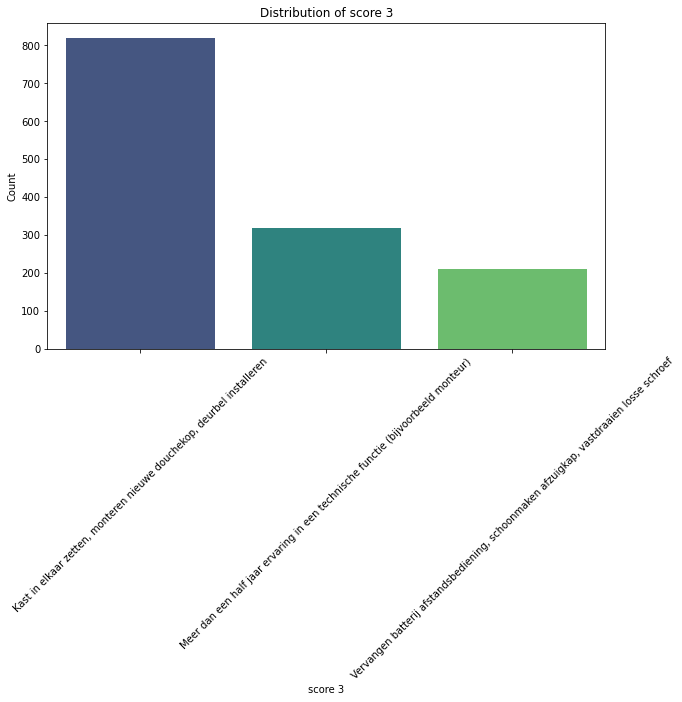

In [69]:
plot_categorical_distribution(df, column)

## Jaar ervaring

In [46]:
from datetime import datetime
import re 

def replace_fun(str_val):
     replace_dict = {
         ',':'.',
         ' ':'',
         'half':'0.5',
         'een': '1',
         'twee': '2',
         'drie': '3',
         'vier': '4',
         'vijf': '5',
         'zes': '6',
         'zeven': '7',
         'acht': '8',
         'negen': '9',
         'months':'maanden',
         'jaren':'jaar'
     }
     for orig, new in replace_dict.items():
         str_val = str_val.replace(orig, new)
         
     return str_val 

def extract_vals(str_val):
    try:
        #re.match(r'^-?\d+(?:\.\d+)$', str_val) is None: # geen float
        val = float(str_val)
        return val
    except:
        if str_val in ['niet','geen']:
            val = 0
            return val
        elif 'sinds' in str_val or 'vanaf' in str_val:
            matches = re.findall('(\d{4})',str_val)
            if len(matches) == 0:
                val = np.nan
            else:
                val = float(matches[0])
            return val
        if 'jaar' in str_val:
            pattern = r'(\d+\.\d+|\d+)\s*jaar'
        elif 'maand' in str_val:
            pattern = r'(\d+\.\d+|\d+)\s*maand'
        else:
            val = np.nan
            return val
        matches = re.findall(pattern, str_val)
        if len(matches) == 0:
            val = np.nan
        else:
            numbers = [float(match) for match in matches]
            val = numbers[0]
            if 'maand' in str_val:
                val = val/12
        
        return val

# Calculate the number of years worked
def calculate_years_worked(row):
    start_year = row['jaar_ervaring']
    end_date = row['cdate']
    
    if isinstance(end_date, datetime):
        piet= 0
    else:
        end_date = datetime(2024,1,1)
    # If start_year is a float, separate the year and the fraction
    year = int(start_year)
    fraction = start_year - year
    
    # Calculate the number of full years
    years_worked = end_date.year - year
    
    # Adjust for the fraction of the year
    if fraction > 0:
        # Calculate the exact date by adding the fraction as months
        start_date = datetime(year, 1, 1) + pd.DateOffset(months=int(fraction * 12))
        if end_date < start_date:
            years_worked -= 1
        elif end_date > start_date:
            extra_months = (end_date - start_date).days / 365.25
            years_worked += extra_months
    
    return years_worked


def bereken_jaar_ervaring(df):
    df.loc[df['Hoe lang in dienst/werkloos'] == 'Vijf een half jaar', 'Hoe lang in dienst/werkloos'] = '5.5jaar'

    df['jaar_ervaring'] = df['Hoe lang in dienst/werkloos'].apply(lambda x: extract_vals(replace_fun(x.lower())) if isinstance(x, str) else x)
    df.loc[df['jaar_ervaring'] > 1950, 'jaar_ervaring'] = df[df['jaar_ervaring'] > 1950].apply(calculate_years_worked,axis=1)
    return df

df = bereken_jaar_ervaring(df)

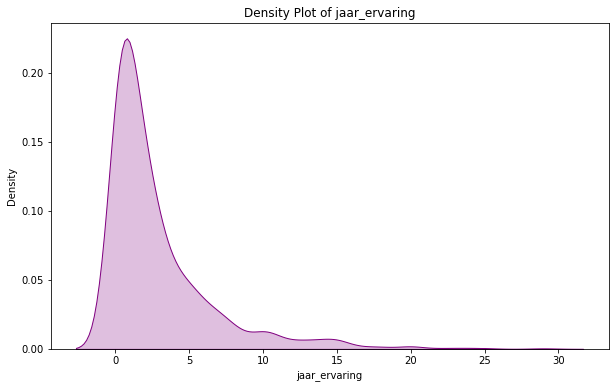

In [47]:
plot_density(df, 'jaar_ervaring')

In [72]:
df['jaar_ervaring'].sort_values()

37      0.0
8696    0.0
8686    0.0
8363    0.0
8193    0.0
       ... 
9673    NaN
9735    NaN
9737    NaN
9771    NaN
9772    NaN
Name: jaar_ervaring, Length: 4088, dtype: float64

## Convert postcode

In [48]:
def convert_postcode(df):
    # postcode > stad, provincie, randstad ja/nee
    df['postcode_getal'] = df['postcode'].str[:4]
    postal_code_data = pd.read_excel('data/postcodesNL.xlsx',converters={'Postcode':str})
    df = df.merge(postal_code_data, left_on='postcode_getal', right_on='Postcode', how='left')

    randstad_list = ['Amsterdam','Rotterdam','Den Haag','Utrecht','Almere','Haarlem','Amersfoort','Zaanstad','Haarlemmermeer','Zoetermeer','Leiden','Dordrecht','Alphen aan den Rijn','Westland','Alkmaar','Delft']
    df['randstad'] = df['Gemeente'].isin(randstad_list)
    df.loc[df['Gemeente'].isna(), 'randstad'] = np.nan
    df.loc[df['postcode'] == 'Overig', 'randstad']=False
    df.drop(['postcode'], axis=1, inplace=True)
    return df

In [49]:
df = convert_postcode(df)

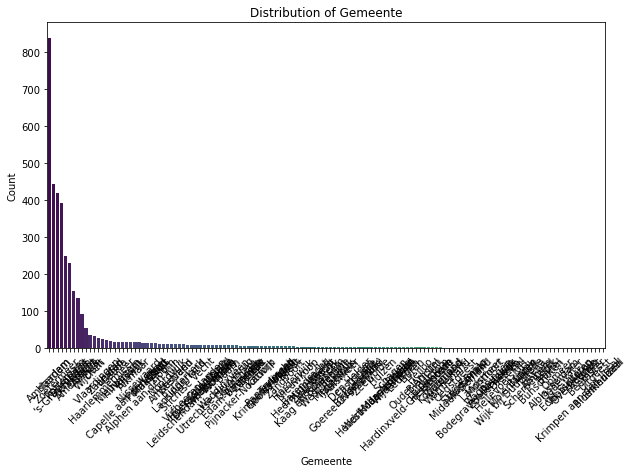

In [50]:
plot_categorical_distribution(df,'Gemeente')

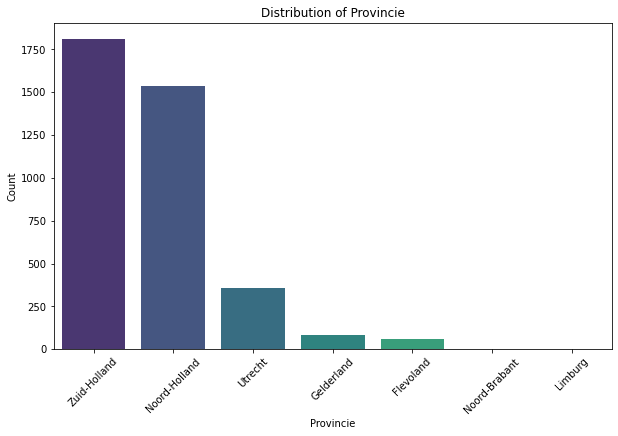

In [51]:
plot_categorical_distribution(df,'Provincie')

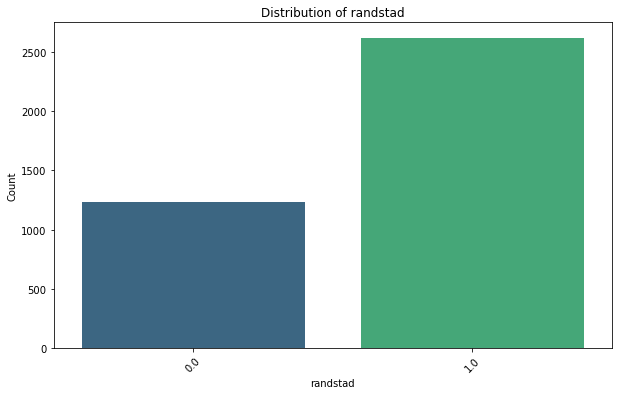

In [52]:
plot_categorical_distribution(df,'randstad')

## Werksituatie

In [53]:
def clean_werksituatie(df):
       df['Werksituatie'] = df['Werksituatie'].str.lower()
       df['Werksituatie'].replace("werkloos","ik ben werkloos",inplace=True)
       klus_answers = [ 'niks: 0 klussen',
              'weinig: 3 tot 4 klussen', 'regelmatig: 5 tot 8 klussen',
              'bij uitzondering: 1 tot 2 klussen', 'veel: meer dan 8 klussen']
       df['Werksituatie'] = df['Werksituatie'].apply(lambda x: "ik ben zzp'er" if x in klus_answers else x)
       answers = ['ik heb een tijdelijk contract (bepaalde tijd)', 'ik ben werkloos',
              'ik heb een vast contract', "ik ben zzp'er"]
       df['Werksituatie'] = df['Werksituatie'].apply(lambda x: np.nan if x not in answers else x)
       return df

In [54]:
df = clean_werksituatie(df)

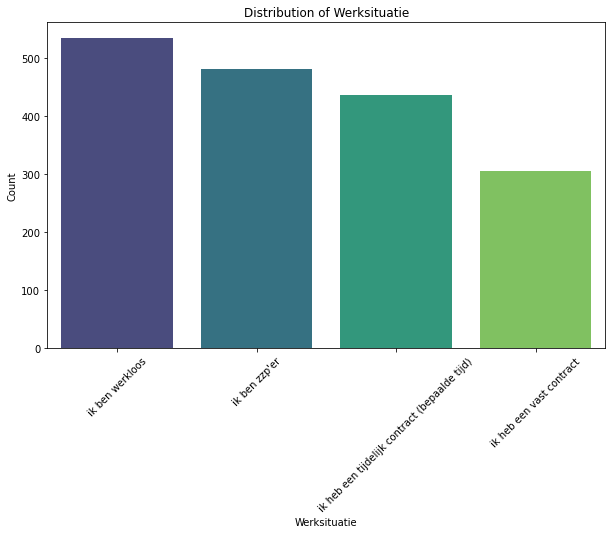

In [55]:
column = "Werksituatie"
plot_categorical_distribution(df, column)

In [81]:
df['Voorkeursbranche'] = df['Voorkeursbranche'].str.lower()

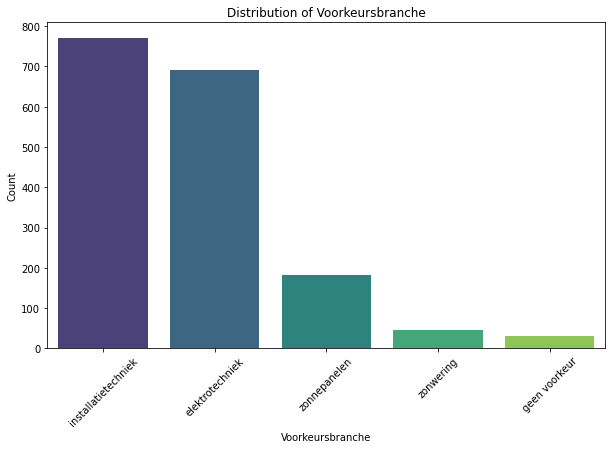

In [82]:
column = "Voorkeursbranche"
plot_categorical_distribution(df, column)

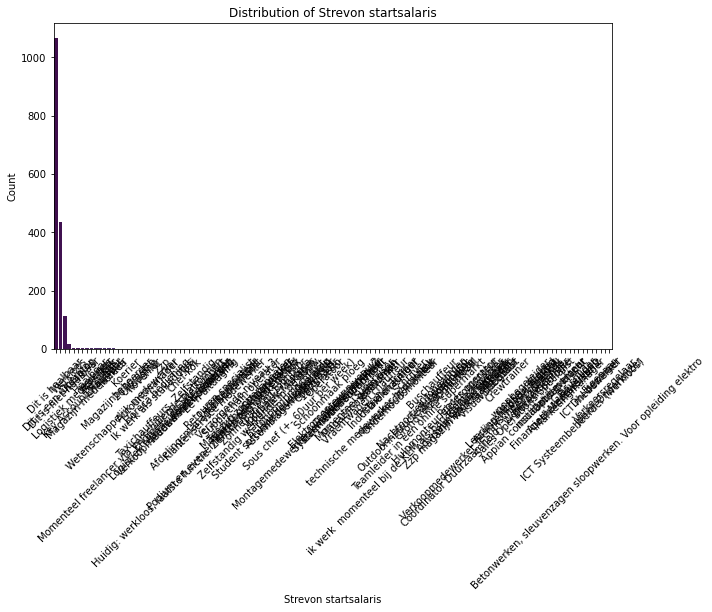

In [83]:
column = "Strevon startsalaris"
plot_categorical_distribution(df, column)

In [84]:
def clean_strevon_startsalaris(df):
    answers = ["Dit is haalbaar", "Dit is een uitdaging", "Dit is niet haalbaar"]
    df[column] = df[column].apply(lambda x: np.nan if x not in answers else x)
    return df

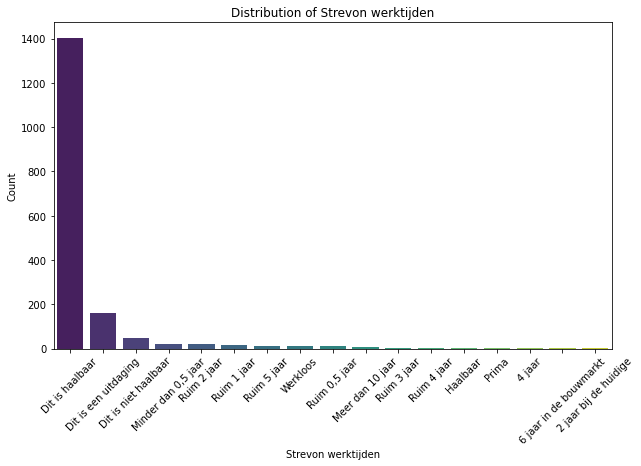

In [85]:
column = "Strevon werktijden"
plot_categorical_distribution(df, column)

In [86]:
answers = ["Dit is haalbaar", "Dit is een uitdaging", "Dit is niet haalbaar"]
df[column] = df[column].apply(lambda x: np.nan if x not in answers else x)

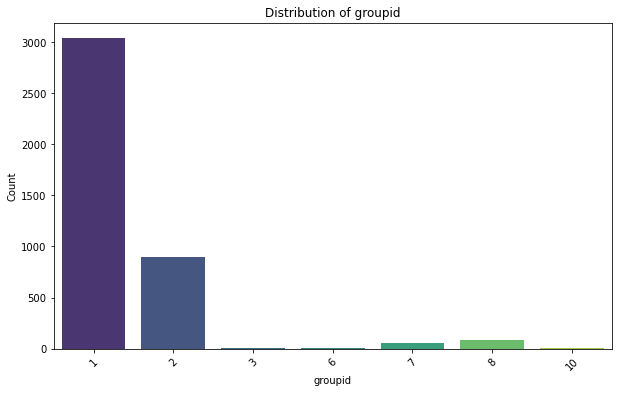

In [87]:
column = "groupid"
plot_categorical_distribution(df, column)

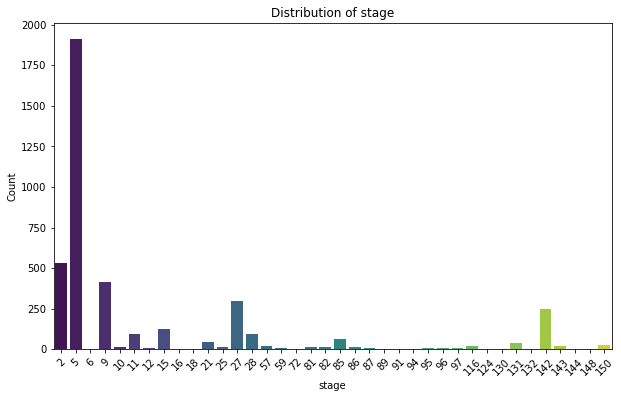

In [88]:
column = "stage"
plot_categorical_distribution(df, column)

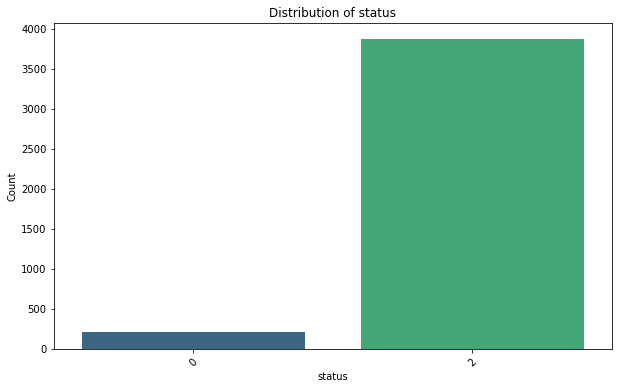

In [89]:
column = "status"
plot_categorical_distribution(df, column)

In [ ]:
df['diff_days'] = (df['belafspraak'] - df['cdate']).dt.days
df[['cdate', 'belafspraak','diff_days']]

In [57]:
def drop_columns(df):
    dropcols = ["Motivatie", "Huidig/Laatste functie", 'Hoe lang in dienst/werkloos',
                'Meest trotste project', "uitkomstTelefonischContact", "Overname bedrag (W&S)",
                "Verloning marge stopper of W&S overname", "berekening", 'postcode_getal', 'Postcode']
    dropcols = [col for col in dropcols if col in df.columns.to_list()]
    
    for col in dropcols:
        df.drop(col ,axis=1,inplace=True)
    return df


In [59]:
df = drop_columns(df)

In [92]:
date_cols = ['cdate','geboortedatum','belafspraak']
for col in date_cols:
    df[col] = pd.to_numeric(df[col])
    #df[col] = df[col].apply(lambda x: float(pd.Timestamp(x)) )

In [93]:
cols = df.columns.to_list()
cols.remove('starter')

In [ ]:
def prep_dataset_for_modelling(df):
    # Identify columns with object data type (categorical variables)
    categorical_columns = df.select_dtypes(include=['object']).columns
    for cat_col in categorical_columns:
        df = clean_categorical_variable(df, cat_col)

    # Identify non-object type columns
    non_categorical_columns = df.select_dtypes(exclude=['object']).columns

    # Dummy code the categorical columns
    df_dummies = pd.get_dummies(df[categorical_columns])

    # Select non-categorical columns
    df_non_categorical = df[non_categorical_columns]

    # Concatenate the dummy coded variables with the non-categorical columns
    df_final = pd.concat([df_non_categorical, df_dummies], axis=1)
    return df_final

In [94]:
# Identify columns with object data type (categorical variables)
categorical_columns = df.select_dtypes(include=['object']).columns

# Identify non-object type columns
non_categorical_columns = df.select_dtypes(exclude=['object']).columns

# Dummy code the categorical columns
df_dummies = pd.get_dummies(df[categorical_columns])

# Select non-categorical columns
df_non_categorical = df[non_categorical_columns]

# Concatenate the dummy coded variables with the non-categorical columns
df_final = pd.concat([df_non_categorical, df_dummies], axis=1)

In [95]:
# # Calculate the sum of each column
# column_sums = df_final.sum()

# # Identify columns where the sum is greater than 10
# columns_to_keep = column_sums[column_sums > 10].index

# # Drop columns that don't sum to more than 10
# df_final_filtered = df_final[columns_to_keep]

In [96]:
df_final.columns.to_list()

['belafspraak',
 'leeftijd',
 'geboortedatum',
 'groupid',
 'stage',
 'status',
 'starter',
 'jaar_ervaring',
 'diff_days',
 'recruiter_Isabelle Walschots',
 'recruiter_Jermaine Symons',
 'recruiter_Job Bruinsma',
 'recruiter_Job van den Berg',
 'recruiter_Lennart Huibers',
 'recruiter_Richard Felix Omondi',
 'recruiter_Wim Van Ginkel',
 'utm_source_bing',
 'utm_source_facebook',
 'utm_source_fb-ig',
 'utm_source_google',
 'utm_source_indeed',
 'utm_source_nationaleberoepengids',
 'utm_source_other',
 'utm_source_strevon',
 'utm_source_tiktok',
 'utm_source_undefined',
 'utm_medium_cpc',
 'utm_medium_organic',
 'utm_medium_social',
 'utm_medium_undefined',
 'utm_campaign_algemeen_amsterdam',
 'utm_campaign_algemeen_rotterdam',
 'utm_campaign_awareness',
 'utm_campaign_branding',
 'utm_campaign_chat-popup',
 'utm_campaign_consideration',
 'utm_campaign_consideration_elektromonteur',
 'utm_campaign_elektromonteur',
 'utm_campaign_elektromonteur_amsterdam',
 'utm_campaign_elektromonteur_r

In [97]:
df_final.to_csv("data\df_final_filtered2.csv",index=False)

In [98]:
len(df_final.columns)

787

In [99]:
len(df_final_filtered.columns)

340

In [100]:
df_final_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4088 entries, 0 to 4087
Columns: 340 entries, belafspraak to randstad_1.0
dtypes: float64(3), int64(6), uint8(331)
memory usage: 1.6 MB


In [101]:
# Calculate the correlation of each column with the target column 'starter'
correlations = df_final_filtered.corrwith(df_final_filtered['starter'])

# Create a list of correlations
correlation_list = correlations.drop('starter').tolist()  # Drop the target column itself from the list

# Create a list of column names
column_names = correlations.drop('starter').index.tolist()  # Drop the target column itself from the list

# Combine column names and correlations into a list of tuples
correlation_tuples = list(zip(column_names, correlation_list))
# Sort the list of tuples by the absolute value of the correlation coefficients in descending order
sorted_correlations = sorted(correlation_tuples, key=lambda x: abs(x[1]), reverse=True)

# Display the sorted list of correlations
print("\nSorted list of strongest correlations with 'starter':")
for column, corr in sorted_correlations:
    print(f"{column}: {corr}")


Sorted list of strongest correlations with 'starter':
groupid: 0.8712109490384147
status: -0.807114984830384
GroupTitle_CS - Fase 3 - Afsluitend: 0.7494341007854056
StageTitle_Gestopt : 0.6648066717811957
GroupTitle_CS - Fase 2 - Actief: 0.6041580040880827
uitkomstTelefonischDeal_Intake: 0.32346349798918517
GroupTitle_RC - Fase 1 - Leads: -0.3224680338815102
stage: 0.30724286809575535
StageTitle_Kwartaal 4 : 0.2738169667091408
StageTitle_Kwartaal 5: 0.2738169667091398
StageTitle_Op vast contract: 0.2502883872456573
StageTitle_Bel afspraken: -0.17808205463539103
Voorkeursbranche_elektrotechniek: 0.10692695969329467
Voorkeursbranche_installatietechniek: 0.10319623826265387
GroupTitle_RC - Fase 2 - Intakes: -0.0937488272804685
uitkomstTelefonischDeal_Nam niet op: -0.08248393548326007
Voorkeursbranche_zonwering: 0.08241495581956736
StageTitle_2e telefonisch contactpoging: -0.07353219809500867
StageTitle_Intakes gepland: -0.06359339133681274
uitkomstTelefonischDeal_Niet geschikt - slechte 

In [102]:
df_corr = pd.DataFrame(sorted_correlations,columns=['variable','correlation'])
df_corr

,variable,correlation
0,groupid,0.871211
1,status,-0.807115
2,GroupTitle_CS - Fase 3 - Afsluitend,0.749434
3,StageTitle_Gestopt,0.664807
4,GroupTitle_CS - Fase 2 - Actief,0.604158
...,...,...
334,utm_campaign_location_rotterdam,-0.000789
335,utm_adgroup_other,0.000749
336,utm_adgroup_no_loc_loodgieter_opleiding,0.000326
337,utm_source_tiktok,-0.000166


In [103]:
df_corr.iloc[50:100].head(50)

,variable,correlation
50,pagina_opleidingstrajecten/elektrotechniek/bbl,0.031999
51,utm_source_fb-ig,-0.031966
52,Strevon startsalaris_Dit is niet haalbaar,-0.031692
53,conversiepunt_website,0.031515
54,uitkomstTelefonischDeal_Geen interesse - wil e...,-0.031397
55,uitkomstTelefonischDeal_Niet geschikt - leefti...,-0.031100
56,recruiter_Jermaine Symons,-0.030402
57,pagina_opleidingstrajecten/installatietechniek...,-0.030346
58,score 1_Meer dan een half jaar ervaring in een...,-0.030035
59,StageTitle_Actie Recruiter,-0.029418


In [104]:
pd.DataFrame(df.describe(datetime_is_numeric=True))

,cdate,recruitercode,belafspraak,leeftijd,geboortedatum,groupid,stage,status,starter,jaar_ervaring,diff_days
count,4.129000e+03,3658.000000,4.129000e+03,3911.000000,4.129000e+03,4129.000000,4129.000000,4129.000000,4129.000000,1312.000000,3931.000000
mean,1.686814e+18,7.134773,1.165319e+18,31.490667,-4.903762e+18,1.455074,22.014774,1.870671,0.032938,2.873336,27.263801
std,1.901531e+16,2.232737,2.331884e+18,9.454906,4.943744e+18,1.253089,38.768113,0.491926,0.178495,3.713893,95.260101
min,1.627646e+18,1.000000,-9.223372e+18,17.000000,-9.223372e+18,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000
25%,1.671203e+18,7.000000,1.669627e+18,24.000000,-9.223372e+18,1.000000,5.000000,2.000000,0.000000,0.500000,1.000000
50%,1.689267e+18,7.000000,1.688974e+18,29.000000,-9.223372e+18,1.000000,5.000000,2.000000,0.000000,1.500000,2.000000
75%,1.702504e+18,9.000000,1.704703e+18,38.000000,7.318944e+17,2.000000,15.000000,2.000000,0.000000,4.000000,6.000000
max,1.716994e+18,12.000000,1.717574e+18,64.000000,1.684973e+18,10.000000,148.000000,2.000000,1.000000,29.000000,893.000000


In [105]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4129 entries, 0 to 4128
Data columns (total 38 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   cdate                                 4129 non-null   int64  
 1   recruitercode                         3658 non-null   float64
 2   belafspraak                           4129 non-null   int64  
 3   utm_source                            3956 non-null   object 
 4   utm_medium                            4049 non-null   object 
 5   utm_campaign                          2083 non-null   object 
 6   utm_adgroup                           1533 non-null   object 
 7   conversiepunt                         3888 non-null   object 
 8   pagina                                3411 non-null   object 
 9   uitkomstTelefonischDeal               3820 non-null   object 
 10  leeftijd                              3911 non-null   float64
 11  geboortedatum    

In [106]:
pd.DataFrame(df[['cdate','geboortedatum','belafspraak']].describe(datetime_is_numeric=True))

,cdate,geboortedatum,belafspraak
count,4.129000e+03,4.129000e+03,4.129000e+03
mean,1.686814e+18,-4.903762e+18,1.165319e+18
std,1.901531e+16,4.943744e+18,2.331884e+18
min,1.627646e+18,-9.223372e+18,-9.223372e+18
25%,1.671203e+18,-9.223372e+18,1.669627e+18
50%,1.689267e+18,-9.223372e+18,1.688974e+18
75%,1.702504e+18,7.318944e+17,1.704703e+18
max,1.716994e+18,1.684973e+18,1.717574e+18


In [107]:
df['geboortedatum'].iloc[0]

965433600000000000

In [108]:
date_cols = ['cdate','geboortedatum','belafspraak']
for col in date_cols:
    df[col] = pd.to_numeric(df[col])
    #df[col] = df[col].apply(lambda x: float(pd.Timestamp(x)) )

In [109]:
for col in df.columns.to_list():
    #print(f"{col}") 
    print(f"{len(df[df[col].isna()])}") 

0
471
0
173
80
2046
2596
241
718
309
218
0
2338
2339
2754
2766
2768
2392
2326
2475
2474
0
0
0
0
3568
2046
3586
2596
697
218
2339
2817
235
235
235
235
198
